In [1]:
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem.snowball import ItalianStemmer
from collections import Counter
from wordcloud import WordCloud
import nltk
from IPython.display import Image 
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download("stopwords") # nltk needs us to manually download the set of stopwords

def get_file_tokens(filename):
    tokens = []
    for line in filename:
        tokens += re.split('\W+', line,  flags=re.UNICODE) # re library deals with the splitting
    return tokens

def generate_tag_cloud(freq, image_filename=None):
	wc = WordCloud(background_color="white").generate_from_frequencies(freq)
	if image_filename:
        # If you pass it a filename, then it saves the image on the provided path
		image = wc.to_image()
		image.save(image_filename)
	else:
        # then it just displays it here on the notebook
		plt.imshow(wc, interpolation='bilinear')
		plt.axis("off")
		plt.show()
        
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('italian'))

def filter_words(words):
    return [w for w in words if len(w)>=3 and w not in STOPWORDS]

def normalize_words(words):
    return [unidecode(w.lower()) for w in words]

def stem_words(words):
	s = ItalianStemmer()
	return [s.stem(w) for w in words]

def get_stem_mapping(words):
	s = ItalianStemmer() 
	mapping = {} # here is our mapping
	for w in words: 
		stemmed_w = s.stem(w)
		if stemmed_w not in mapping: 
			mapping[stemmed_w] = Counter()
		mapping[stemmed_w].update([w])

	return mapping

def destem_words(stems, stem_mapping):
	return [stem_mapping[s].most_common(1)[0][0] for s in stems] # ask the counter to get the most common occurrence for each root word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
import os
import pandas as pd

def leggi_file_csv_in_sottocartelle(directory):
    # Lista dei DataFrame letti dai file CSV
    elenco_dataframe = []

    # Naviga attraverso tutte le sottocartelle e file nella directory data
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                # Costruisci il percorso completo del file
                file_path = os.path.join(root, file)
                # Leggi il file CSV e aggiungi il DataFrame alla lista
                df = pd.read_csv(file_path)
                elenco_dataframe.append(df)

    # Concatena tutti i DataFrame in un unico DataFrame
    dataframe_completo = pd.concat(elenco_dataframe, ignore_index=True)
    
    return dataframe_completo

# Specifica la directory radice in cui cercare i file CSV
directory_radice = 'C:/Users/RConti/PycharmProjects/pythonProject/PROGETTONE/CityNews_SCraper'

# Chiama la funzione per leggere e concatenare i file CSV nelle sottocartelle
tutti_i_dati = leggi_file_csv_in_sottocartelle(directory_radice)

In [3]:
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox, Layout
import warnings
warnings.filterwarnings("ignore")

# Sample DataFrame with longer category names
df = tutti_i_dati

# Dropdown options (list of Territorio)
dropdown_options = sorted(df['Edizione'].unique().tolist())

# Function to update chart1 based on selected category
def update_chart1(Edizione):
    filtered_df = df[df['Edizione'] == Edizione]

    Testo = filtered_df['Testo'].to_list()
    tokens = get_file_tokens(Testo)
    filtered_t = filter_words(normalize_words(tokens))
    stemmed = stem_words(filtered_t)
    stem_mapping = get_stem_mapping(filtered_t)
    destemmed = destem_words(stemmed, stem_mapping)
    c = Counter(destemmed)

    generate_tag_cloud(c)

    '''y = [count for tag, count in c.most_common(20)]
    x = [tag for tag, count in c.most_common(20)]
    
    plt.barh(x, y)
    plt.gca().invert_yaxis()
    plt.show()'''

    c_df = pd.DataFrame(list(c.items()), columns=['Word', 'Count'])

    # Sort the DataFrame by the 'Count' column in descending order
    df_sorted = c_df.sort_values(by='Count', ascending=False)

    # Select the top 20 rows
    top_20 = df_sorted.head(20)

    chart = alt.Chart(top_20).mark_bar().encode(
        x = 'Count:Q',
        y = alt.Y('Word:N', title='Word', sort='-x'),
        size=alt.Size(field='Count', type='quantitative', bin=alt.BinParams(maxbins=5)),
        color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
        tooltip=['Word', 'Count']
    )
    
    display(chart)

    '''nltk_text = nltk.Text(tokens)
    nltk_text.dispersion_plot(top_20['Word'].to_list())'''

dropdown_edizione = widgets.Dropdown(
    options=dropdown_options,
    value=dropdown_options[0],  # Set initial value
    description='Select Edizione:',
    style={'description_width': 'initial'}  # Set description width to full
)  

# Initial display of charts and dropdowns side by side
output1 = widgets.Output()

with output1:
    display(VBox([dropdown_edizione]))
    update_chart1(dropdown_edizione.value)

# Arrange the outputs (charts) horizontally using HBox layout
display(output1)

# Set up event handlers for dropdowns
def on_edizione_change(change):
    with output1:
        clear_output(wait=True)
        display(VBox([dropdown_edizione]))
        update_chart1(change.new)

dropdown_edizione.observe(on_edizione_change, names='value')

Output()

#### TagMe

In [4]:
import requests # For REST calls
import json # for modelling objects in the JSON format

# This line opens the file from the file system, the file is in the same folder of the notebook and it is opened in "read-only mode"
with open("config.json", 'r') as json_file:
    config = json.load(json_file) # load the json object inside the config file
    KEY = config['d4science_KEY'] # this is the key we will be using for REST calls

TAGME_ENDPOINT = "https://tagme.d4science.org/tagme/tag"
LANG = "it" # Also works in italian and german

In [92]:
def query_tagme(text, long_text=False):
    payload = {"text": text, "gcube-token": KEY, "lang": LANG}
    if long_text:
        # long_text is by defaul false, but if specified by the user, we set the window size at 5
        payload["long_text"] = 5
    r = requests.post(TAGME_ENDPOINT, payload)
    if r.status_code != 200:
        raise Exception("Error on text: {}\n{}".format(text, r.text))
    return r.json()
    
# Try changing the min_rho parameter and see how it impacts the returned entities
def get_tagme_entities(tagme_response, min_rho=0.001, min_link=0.001):
    ann = tagme_response["annotations"]
    ann = [a for a in ann if a["rho"] > min_rho] # filter all the annotations with a rho score lower than the threshold
    ann = [a for a in ann if a["link_probability"] > min_link] # filter all the annotations with a rho score lower than the threshold
    return [a["title"] for a in ann if "title" in a] # return just the page titles

In [93]:
text = tutti_i_dati['Testo'].to_list()

print("BEFORE FILTERING")
resp = query_tagme(text, long_text=True) 
before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
before_filtering

BEFORE FILTERING


['Agricoltura',
 'Allevamento',
 'Ginocchio',
 'Manifestazione',
 'Sciacca',
 'Mattino',
 'Stato federale',
 'Movimento (sociologia)',
 'Agricoltura',
 'Italiani',
 'Stato federale',
 'Comitato (ordinamento civile italiano)',
 'Associazione (diritto)',
 'Terra e Vita',
 'La vita è',
 "Circolo dell'Unione (Firenze)",
 'La Rinascente',
 'Iniziativa (scacchi)',
 'Necessità',
 'Autorità',
 'Stato della materia',
 'La Grave',
 'Sofferenza',
 'Pressione',
 'Costo',
 'Gestione, amministrazione, esercizio',
 'Produzione',
 'Imposta sul reddito delle persone fisiche',
 'Legge di bilancio',
 'Acqua',
 'Lago Arancio',
 'Inquinamento',
 'Rhodophyta',
 'Corteo storico (Palio di Siena)',
 'Trattore agricolo',
 'Provincia di Siena',
 'Unomattina',
 'Sciacca',
 'Compagnia di Gesù',
 "Direttore d'orchestra",
 'Vettore (matematica)',
 'Menfi',
 'Università degli Studi di Milano',
 'Produzione',
 'Valle del Belice',
 'Sinistra Indipendente',
 'Contestazione',
 'Governo',
 'Renato Schifani',
 'Corrente co

In [94]:
# Lista vuota per memorizzare i risultati della trasformazione
risultati = []

# Ciclo for per iterare attraverso ciascuna lista interna
for i in range(0, len(text)):
    resp = query_tagme_with_date(text[i], long_text=True) 
    before_filtering = [a["title"] for a in resp['annotations'] if "title" in a]
    risultati.append(before_filtering)

# Visualizzare i risultati
#print(risultati)


In [95]:
# Utilizzare una comprensione di lista per condensare gli elementi
lista_condensata = [elemento for lista_interna in risultati for elemento in lista_interna]

# Visualizzare la lista condensata
#print(lista_condensata)

In [96]:
len(lista_condensata)

55013

In [28]:
print("AFTER FILTERING")
after_filtering = get_tagme_entities(resp)
len(after_filtering)

AFTER FILTERING


232

In [97]:
import pandas as pd

comuni_df = pd.read_excel('Codici-statistici-e-denominazioni-al-22_01_2024.xlsx')

lista_comuni = comuni_df['Denominazione in italiano'].to_list()

# Convertiamo le liste in set e calcoliamo l'intersezione
intersezione = list(set(lista_condensata) & set(lista_comuni))

# Visualizziamo il risultato
len(intersezione)

487

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RConti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


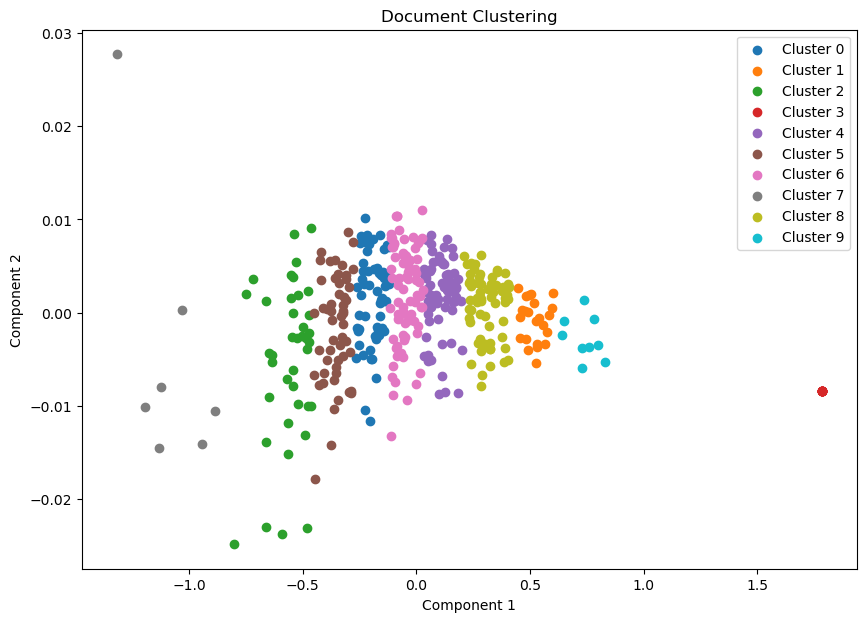

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Scaricare le risorse di NLTK necessarie
nltk.download('punkt')
nltk.download('stopwords')

documents = tutti_i_dati['Testo'].to_list()

# Esempio di documenti
'''documents = [
    "Questo è il primo documento.",
    "Questo documento è il secondo documento.",
    "E questo è il terzo documento.",
    "Il quarto documento è qui."
]'''

# Pre-processamento: tokenizzazione, rimozione stopwords e punteggiatura
stop_words = set(stopwords.words('italian'))
def preprocess(document):
    tokens = word_tokenize(document.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# Allenamento del modello Word2Vec
model = Word2Vec(sentences=processed_docs, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Calcolare i document embeddings
def document_embedding(document, model):
    valid_words = [word for word in document if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

document_embeddings = np.array([document_embedding(doc, model) for doc in processed_docs])

# Applicare KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(document_embeddings)
labels = kmeans.labels_

# Riduzione della dimensionalità con PCA o TSNE
# Usare PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(document_embeddings)

# Alternativa: usare TSNE
# tsne = TSNE(n_components=2, random_state=0)
# reduced_embeddings = tsne.fit_transform(document_embeddings)

# Plotting
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    points = reduced_embeddings[labels == i]
    plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

plt.title("Document Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

In [89]:
pd.set_option('display.max_rows', None)

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_term="manifestazione", topn=1000):
    results = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se "manifestazione" è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word == filter_term and score >= score_threshold:
                    results.append((word, similar_word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
filtered_similar_words = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_term="manifestazione", topn=1000)

# Creare un DataFrame dai risultati filtrati
df = pd.DataFrame(filtered_similar_words, columns=["Parola Chiave", "Simile a", "Punteggio"])

df

Parola 'castel morrone' non presente nel modello.
Parola 'motta di livenza' non presente nel modello.
Parola 'sala comacina' non presente nel modello.
Parola 'montecorvino pugliano' non presente nel modello.
Parola 'castel del piano' non presente nel modello.
Parola 'anguillara sabazia' non presente nel modello.
Parola 'san daniele del friuli' non presente nel modello.
Parola 'lercara friddi' non presente nel modello.
Parola 'castelfranco veneto' non presente nel modello.
Parola 'san valentino in abruzzo citeriore' non presente nel modello.
Parola 'castel san giovanni' non presente nel modello.
Parola 'cerreto d'esi' non presente nel modello.
Parola 'masera' non presente nel modello.
Parola 'castello d'argile' non presente nel modello.
Parola 'breda di piave' non presente nel modello.
Parola 'cascina' non presente nel modello.
Parola 'vibo valentia' non presente nel modello.
Parola 'fara olivana con sola' non presente nel modello.
Parola 'mercato saraceno' non presente nel modello.
Par

,Parola Chiave,Simile a,Punteggio
0,salerno,manifestazione,0.988971
1,lodi,manifestazione,0.976569
2,colonna,manifestazione,0.979260
3,portici,manifestazione,0.982789
4,udine,manifestazione,0.993360
5,casarano,manifestazione,0.956613
6,napoli,manifestazione,0.996780
7,pisa,manifestazione,0.985668
8,bari,manifestazione,0.998429
9,faenza,manifestazione,0.975468


In [87]:
import pandas as pd

# Funzione per ottenere parole simili e filtrare i risultati per includere "manifestazione" e "corteo" con un punteggio sopra una soglia
def most_similar_filtered(model, positive, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000):
    results_raduno = []
    results_manifestazione = []
    for word in positive:
        try:
            # Ottieni parole simili per la parola corrente
            similar_words = model.wv.most_similar(positive=[word], topn=topn)
            
            # Cerca se una delle parole filtro è tra i risultati con un punteggio sopra la soglia
            for similar_word, score in similar_words:
                if similar_word in filter_terms and score >= score_threshold:
                    if similar_word == "corteo":
                        results_raduno.append((word, score))
                    elif similar_word == "manifestazione":
                        results_manifestazione.append((word, score))
        except KeyError:
            # La parola non è presente nel modello, continua con la prossima
            print(f"Parola '{word}' non presente nel modello.")
            continue
    
    return results_raduno, results_manifestazione

# Lista di parole positive
positive_words = intersezione

# Converti tutte le stringhe in minuscolo
positive_words_lower = [s.lower() for s in positive_words]

# Ottieni i risultati filtrati con le parole convertite in minuscolo
results_corteo, results_manifestazione = most_similar_filtered(model, positive=positive_words_lower, score_threshold=0.9, filter_terms=["corteo", "manifestazione"], topn=1000)

# Creare un DataFrame dai risultati filtrati
df_corteo = pd.DataFrame(results_corteo, columns=["Parola Chiave", "Punteggio per Corteo"])
df_manifestazione = pd.DataFrame(results_manifestazione, columns=["Parola Chiave", "Punteggio per Manifestazione"])

# Unire i due DataFrame basati sulla colonna "Parola Chiave"
df = pd.merge(df_corteo, df_manifestazione, on="Parola Chiave", how="outer")

df

Parola 'castel morrone' non presente nel modello.
Parola 'motta di livenza' non presente nel modello.
Parola 'sala comacina' non presente nel modello.
Parola 'montecorvino pugliano' non presente nel modello.
Parola 'castel del piano' non presente nel modello.
Parola 'anguillara sabazia' non presente nel modello.
Parola 'san daniele del friuli' non presente nel modello.
Parola 'lercara friddi' non presente nel modello.
Parola 'castelfranco veneto' non presente nel modello.
Parola 'san valentino in abruzzo citeriore' non presente nel modello.
Parola 'castel san giovanni' non presente nel modello.
Parola 'cerreto d'esi' non presente nel modello.
Parola 'masera' non presente nel modello.
Parola 'castello d'argile' non presente nel modello.
Parola 'breda di piave' non presente nel modello.
Parola 'cascina' non presente nel modello.
Parola 'vibo valentia' non presente nel modello.
Parola 'fara olivana con sola' non presente nel modello.
Parola 'mercato saraceno' non presente nel modello.
Par

,Parola Chiave,Punteggio per Corteo,Punteggio per Manifestazione
0,salerno,0.988739,0.988971
1,lodi,0.976524,0.976569
2,colonna,0.979425,0.979260
3,portici,0.982621,0.982789
4,udine,0.993164,0.993360
5,casarano,0.956032,0.956613
6,napoli,0.996473,0.996780
7,pisa,0.985892,0.985668
8,bari,0.998260,0.998429
9,faenza,0.975959,0.975468


In [28]:
intersezione = df['Parola Chiave'].to_list()
intersezione

['salerno',
 'lodi',
 'colonna',
 'portici',
 'udine',
 'casarano',
 'napoli',
 'pisa',
 'bari',
 'faenza',
 'cerignola',
 'capua',
 'salento',
 'pontedera',
 'sale',
 'viterbo',
 'benevento',
 'cremona',
 'ponte',
 'carovigno',
 'forlì',
 'como',
 'lenta',
 'nociglia',
 'anzi',
 'lago',
 'rosarno',
 'palermo',
 'fondi',
 'orvieto',
 'milano',
 'paola',
 'argenta',
 'brindisi',
 'casalbordino',
 'trinitapoli',
 'livorno',
 'roma',
 'piacenza',
 'pontecorvo',
 'foggia',
 'conselice',
 'cassino',
 'valmontone',
 'melegnano',
 'grosseto',
 'avellino',
 'cesena',
 'lecco',
 'tarquinia',
 'mese',
 'campagna',
 'modena',
 'frosinone',
 'naro',
 'ferrara',
 'arezzo',
 'capaci',
 'flumeri',
 'aversa',
 'milazzo',
 'lucera',
 'opera',
 'licata',
 'orte',
 'agrigento',
 'siena',
 'ravenna',
 'battipaglia',
 'vita',
 'vasto',
 'lecce',
 'sanremo',
 'trento',
 'rimini',
 'menfi',
 'parma',
 'prato',
 'perugia',
 'modigliana',
 'genova',
 'messina',
 'treviso',
 'premilcuore',
 're',
 'rende',
 'co

In [33]:
it = pd.read_csv('IT.txt', sep='\t', header=None)

In [34]:
it = it.rename(columns={1: 'droppare', 2: 'Comune', 3: 'Regione', 4: 'codice_regione', 9: 'Lat', 10: 'Long'})
it = it.drop(columns=['droppare'])
it_filtrato = it[['Comune', 'Regione', 'codice_regione', 'Lat', 'Long']]
#it_filtrato

In [45]:
it_distinct = it_filtrato.drop_duplicates()
it_distinct["Comune"] = it_distinct["Comune"].str.lower()
#it_distinct

In [46]:
intersezione_df = pd.DataFrame(intersezione, columns=['Comune'])
#intersezione_df

In [48]:
df_inner = pd.merge(it_distinct, intersezione_df, on='Comune', how='inner')
#df_inner

In [49]:
import altair as alt

urlGeo='https://raw.githubusercontent.com/openpolis/geojson-italy/master/topojson/limits_IT_all.topo.json'
italyGeoRegions=alt.topo_feature(urlGeo,'regions')

italyBaseMap=alt.Chart(italyGeoRegions).mark_geoshape(
    fill='lightgray', stroke='white', strokeWidth=1
)

italyBaseMap

alt.Chart(...)

In [50]:
bubbles=alt.Chart(df_inner).mark_circle().encode(
        latitude='Lat:Q',
        longitude='Long:Q',
        tooltip='Comune:N'
        #size='superficie totale - ettari:Q' # come fare i pallini più grandi (hint: cerco range nella documentazione)

    )

(italyBaseMap + bubbles).properties(width=600,height=600)

alt.LayerChart(...)

In [61]:
# Conta le occorrenze distinte nella colonna 'A' e trasforma il risultato in un DataFrame
df_count = df_inner['Regione'].value_counts().reset_index()

# Rinomina le colonne del nuovo DataFrame
df_count.columns = ['Regione', 'Conteggio']
df_count['Regione'] = df_count['Regione'].replace(['Abruzzi'],['Abruzzo'])
df_count

,Regione,Conteggio
0,Emilia-Romagna,23
1,Puglia,17
2,Campania,16
3,Lazio,14
4,Lombardia,14
5,Sicilia,10
6,Toscana,9
7,Abruzzo,7
8,Veneto,6
9,Calabria,6


In [62]:
import pandas as pd
import requests

# Lista delle regioni italiane
regioni_italiane = [
    'Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
    'Friuli-Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
    'Molise', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana',
    'Trentino-Alto Adige', 'Umbria', 'Valle d\'Aosta', 'Veneto'
]

# Funzione per ottenere le coordinate geografiche utilizzando un servizio di geocodifica (es. Nominatim di OpenStreetMap)
def ottieni_coordinate(regione):
    url = f"https://nominatim.openstreetmap.org/search.php?q={regione}, Italy&format=json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return {'Regione': regione, 'lat': lat, 'long': lon}
    return None

# Creazione del DataFrame delle coordinate geografiche delle regioni italiane
coordinate_regioni = [ottieni_coordinate(regione) for regione in regioni_italiane]
coordinate_df = pd.DataFrame(coordinate_regioni)

# Visualizza il DataFrame
coordinate_df

,Regione,lat,long
0,Abruzzo,42.227681,13.854983
1,Basilicata,40.500571,16.081953
2,Calabria,39.0565974,16.5249864
3,Campania,40.860672,14.843984
4,Emilia-Romagna,44.525696,11.039437
5,Friuli-Venezia Giulia,46.151042,13.055904
6,Lazio,41.9808038,12.7662312
7,Liguria,44.4777617,8.7026296
8,Lombardia,45.5703694,9.7732524
9,Marche,43.3458388,13.1415872


In [63]:
import pandas as pd
import altair as alt

# Creazione di un DataFrame di esempio con i codici ISTAT delle regioni italiane
dati = {
    'Regione': ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli-Venezia Giulia',
                'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'Piemonte', 'Puglia', 'Sardegna',
                'Sicilia', 'Toscana', 'Trentino-Alto Adige', 'Umbria', "Valle d'Aosta", 'Veneto'],
    'codice_regione': [13, 17, 18, 15, 8, 6, 12, 7, 3, 11, 14, 1, 16, 20, 19, 9, 4, 10, 2, 5]
}

df_codice_regione = pd.DataFrame(dati)
df_codice_regione

,Regione,codice_regione
0,Abruzzo,13
1,Basilicata,17
2,Calabria,18
3,Campania,15
4,Emilia-Romagna,8
5,Friuli-Venezia Giulia,6
6,Lazio,12
7,Liguria,7
8,Lombardia,3
9,Marche,11


In [67]:
df_final = df_count.merge(coordinate_df, on='Regione', how='right')
df_final_2 = df_final.merge(df_codice_regione, on='Regione', how='inner')
df_final_2

,Regione,Conteggio,lat,long,codice_regione
0,Abruzzo,7.0,42.227681,13.854983,13
1,Basilicata,1.0,40.500571,16.081953,17
2,Calabria,6.0,39.0565974,16.5249864,18
3,Campania,16.0,40.860672,14.843984,15
4,Emilia-Romagna,23.0,44.525696,11.039437,8
5,Friuli-Venezia Giulia,2.0,46.151042,13.055904,6
6,Lazio,14.0,41.9808038,12.7662312,12
7,Liguria,2.0,44.4777617,8.7026296,7
8,Lombardia,14.0,45.5703694,9.7732524,3
9,Marche,1.0,43.3458388,13.1415872,11


In [68]:
df_final_2["Conteggio"].fillna(0, inplace=True)
df_final_2

,Regione,Conteggio,lat,long,codice_regione
0,Abruzzo,7.0,42.227681,13.854983,13
1,Basilicata,1.0,40.500571,16.081953,17
2,Calabria,6.0,39.0565974,16.5249864,18
3,Campania,16.0,40.860672,14.843984,15
4,Emilia-Romagna,23.0,44.525696,11.039437,8
5,Friuli-Venezia Giulia,2.0,46.151042,13.055904,6
6,Lazio,14.0,41.9808038,12.7662312,12
7,Liguria,2.0,44.4777617,8.7026296,7
8,Lombardia,14.0,45.5703694,9.7732524,3
9,Marche,1.0,43.3458388,13.1415872,11


In [65]:
apiCovid='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
df=pd.read_csv(apiCovid, parse_dates=['data'])[['denominazione_regione', 'codice_regione', 'lat', 'long']].drop_duplicates()
df

,denominazione_regione,codice_regione,lat,long
0,Abruzzo,13,42.351222,13.398438
1,Basilicata,17,40.639471,15.805148
2,Calabria,18,38.905976,16.594402
3,Campania,15,40.839566,14.250850
4,Emilia-Romagna,8,44.494367,11.341721
5,Friuli Venezia Giulia,6,45.649435,13.768136
6,Lazio,12,41.892770,12.483667
7,Liguria,7,44.411493,8.932699
8,Lombardia,3,45.466794,9.190347
9,Marche,11,43.616760,13.518875


In [217]:
df_final = df.merge(df_count, on='denominazione_regione', how='inner')
df_final

,denominazione_regione,codice_regione,lat,long,Conteggio
0,Abruzzo,13,42.351222,13.398438,21
1,Basilicata,17,40.639471,15.805148,3
2,Calabria,18,38.905976,16.594402,15
3,Campania,15,40.839566,14.250850,49
4,Emilia-Romagna,8,44.494367,11.341721,62
5,Lazio,12,41.892770,12.483667,35
6,Liguria,7,44.411493,8.932699,10
7,Lombardia,3,45.466794,9.190347,49
8,Marche,11,43.616760,13.518875,24
9,Molise,14,41.557748,14.659161,3


In [69]:
alt.Chart(italyGeoRegions).mark_geoshape(
    stroke='#fff', strokeWidth=0.25
).transform_lookup(
    lookup='properties.reg_istat_code_num', from_=alt.LookupData(data=df_final_2, key='codice_regione', fields=['Regione', 'Conteggio'])
).encode(
    color= alt.Color('Conteggio:Q', scale=alt.Scale(scheme='oranges', type='quantize')),
    tooltip= [
              alt.Tooltip('Conteggio:Q'),
              alt.Tooltip('Regione:N')
              #alt.Tooltip('data:N')
    ]
).project(
    type='mercator'
).properties(
    width=400,
    height=400
).configure_view(
    stroke=None
)

alt.Chart(...)